# Whatever hack - Два стула

## Загрузки

Мы будем использовать Tensorflow Object Detection API 
https://github.com/tensorflow/models/tree/master/research/object_detection

In [1]:
!git clone https://github.com/tensorflow/models

Клонирование в «models»…
remote: Counting objects: 14920, done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 14920 (delta 165), reused 223 (delta 133), pack-reused 14644
Получение объектов: 100% (14920/14920), 423.12 MiB | 13.05 MiB/s, готово.
Определение изменений: 100% (8642/8642), готово.
Распаковка файлов: 100% (2087/2087), готово.


Скомпилируем нужные протобуфы (подробнее по инсталяции всех нужных библиотек и зависимостей https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md)

In [9]:
!cd ./models/research/ && protoc object_detection/protos/*.proto --python_out=.

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import json
import urllib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("./models/research")
sys.path.append("./models/research/object_detection/")
from object_detection.utils import ops as utils_ops
from object_detection.utils import dataset_util

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

Будем дообучать модель faster_rcnn_inception_resnet_v2_atrous_coco. Она имеет хорошие показатели по уровню детекции и скорости. Подробнее про доступные модели https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)

In [13]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_MODEL_CHECKPOINTS = 'training/models/'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/notebooks/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [16]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    #if 'frozen_inference_graph.pb' in file_name:
    #  tar_file.extract(file, os.getcwd())
    if file_name.startswith('model.ckpt.'):
        tar_file.extract(file, PATH_TO_MODEL_CHECKPOINTS)

## Load WhateverHack Images

Тренировочные данные:

In [15]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Scitator/WhateverHack-Baseline/master/task2/train.csv', index_col='id')

Тестовые данные:

In [12]:
test_df = pd.read_csv('https://raw.githubusercontent.com/Scitator/WhateverHack-Baseline/master/task2/test_data.csv', index_col='id')

In [18]:
results = [json.loads(train_df.result[i])['aabb'] for i in range(len(train_df))]

classes_labels = sorted(results[0].keys())
classes_labels_to_ids = {
    classes_labels[i-1]:i for i in range(1, len(classes_labels)+1)
}

non_empty_ids = list(set([k for k in range(len(results)) for i in results[k] if results[k][i]]))

# Скачиваем картинки
Предполагаем, что они лежат у нас в *train_images*, а тестовые картинки в *test_images*.

In [10]:
TRAIN_IMAGES_PATH = 'train_images/'
TEST_IMAGES_PATH = 'test_images/'

In [19]:
def download_images(df, path):
    for index, row in df.iterrows():
        inp = json.loads(row['input'])
        urllib.request.urlretrieve(inp['image'],path + '{}.jpg'.format(index))
        sys.stderr.write('\rDownloaded image {} of {}'.format(index, df.shape[0]))

In [ ]:
download_images(train_df, TRAIN_IMAGES_PATH)
download_images(test_df, TEST_IMAGES_PATH)

## Подготовка данных

Конвертируем тестовые картинки в протобуфы для скармливания tensorflow. Готовый файл запишем в *./training/data/train.record*.

In [38]:
def create_tf_example(image_id, img_path, bboxes):
    image = open(img_path, 'rb')
    image_bytes = image.read()
    
    image = Image.open(img_path)
    width = image.size[0] 
    height = image.size[1]
    filename = bytes(img_path.split('/')[1], 'utf-8')
    image_format = b'jpeg' 
    
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    for key, val in bboxes.items():
        for bbox in val:
            classes_text.append(bytes(key, 'utf-8'))
            classes.append(classes_labels_to_ids[key])
            x_min = np.min([point[0] for point in bbox]) 
            y_min = np.min([point[1] for point in bbox])
            x_max = np.max([point[0] for point in bbox])
            y_max = np.max([point[1] for point in bbox])
            
            xmins.append(x_min)
            xmaxs.append(x_max)
            ymins.append(y_min)
            ymaxs.append(y_max)
    

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(image_bytes),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [39]:
writer = tf.python_io.TFRecordWriter('./training/data/train.record')
print("Non empty images: {}".format(len(non_empty_ids)))
for index, img_id in enumerate(non_empty_ids):
    try:
        tf_example = create_tf_example(img_id, TRAIN_IMAGES_PATH + '{}.jpg'.format(img_id), results[img_id])
        record = tf_example.SerializePartialToString()
        writer.write(record)
    except Exception as e:
        print("Failed to conver {}: {}".format(img_id, str(e)))
    sys.stderr.write("\rProcessed image {} ({} from {})".format(img_id, index, len(non_empty_ids)))
writer.close()

Non empty images: 3459


Processed image 2 (0 from 3459)
Processed image 4 (1 from 3459)
Processed image 5 (2 from 3459)
Processed image 6 (3 from 3459)
Processed image 7 (4 from 3459)
Processed image 9 (5 from 3459)
Processed image 10 (6 from 3459)
Processed image 11 (7 from 3459)
Processed image 13 (8 from 3459)
Processed image 15 (9 from 3459)
Processed image 16 (10 from 3459)
Processed image 19 (11 from 3459)
Processed image 21 (12 from 3459)
Processed image 26 (13 from 3459)
Processed image 27 (14 from 3459)
Processed image 29 (15 from 3459)
Processed image 30 (16 from 3459)
Processed image 31 (17 from 3459)
Processed image 32 (18 from 3459)
Processed image 34 (19 from 3459)
Processed image 35 (20 from 3459)
Processed image 36 (21 from 3459)
Processed image 38 (22 from 3459)
Processed image 39 (23 from 3459)
Processed image 40 (24 from 3459)
Processed image 42 (25 from 3459)
Processed image 43 (26 from 3459)
Processed image 44 (27 from 3459)
Processed image 45 (28 from 3459)
Processed image 46 (29 from 34

Processed image 622 (315 from 3459)
Processed image 627 (316 from 3459)
Processed image 629 (317 from 3459)
Processed image 633 (318 from 3459)
Processed image 635 (319 from 3459)
Processed image 638 (320 from 3459)
Processed image 640 (321 from 3459)
Processed image 641 (322 from 3459)
Processed image 644 (323 from 3459)
Processed image 647 (324 from 3459)
Processed image 649 (325 from 3459)
Processed image 652 (326 from 3459)
Processed image 655 (327 from 3459)
Processed image 656 (328 from 3459)
Processed image 657 (329 from 3459)
Processed image 658 (330 from 3459)
Processed image 659 (331 from 3459)
Processed image 661 (332 from 3459)
Processed image 663 (333 from 3459)
Processed image 664 (334 from 3459)
Processed image 665 (335 from 3459)
Processed image 667 (336 from 3459)
Processed image 672 (337 from 3459)
Processed image 674 (338 from 3459)
Processed image 678 (339 from 3459)
Processed image 679 (340 from 3459)
Processed image 680 (341 from 3459)
Processed image 682 (342 fro

Processed image 1109 (549 from 3459)
Processed image 1111 (550 from 3459)
Processed image 1112 (551 from 3459)
Processed image 1115 (552 from 3459)
Processed image 1118 (553 from 3459)
Processed image 1120 (554 from 3459)
Processed image 1122 (555 from 3459)
Processed image 1123 (556 from 3459)
Processed image 1124 (557 from 3459)
Processed image 1125 (558 from 3459)
Processed image 1132 (559 from 3459)
Processed image 1133 (560 from 3459)
Processed image 1136 (561 from 3459)
Processed image 1139 (562 from 3459)
Processed image 1140 (563 from 3459)
Processed image 1141 (564 from 3459)
Processed image 1142 (565 from 3459)
Processed image 1145 (566 from 3459)
Processed image 1146 (567 from 3459)
Processed image 1147 (568 from 3459)
Processed image 1150 (569 from 3459)
Processed image 1151 (570 from 3459)
Processed image 1154 (571 from 3459)
Processed image 1157 (572 from 3459)
Processed image 1159 (573 from 3459)
Processed image 1161 (574 from 3459)
Processed image 1162 (575 from 3459)
P

Processed image 1810 (900 from 3459)
Processed image 1811 (901 from 3459)
Processed image 1814 (902 from 3459)
Processed image 1817 (903 from 3459)
Processed image 1818 (904 from 3459)
Processed image 1820 (905 from 3459)
Processed image 1821 (906 from 3459)
Processed image 1822 (907 from 3459)
Processed image 1824 (908 from 3459)
Processed image 1828 (909 from 3459)
Processed image 1829 (910 from 3459)
Processed image 1831 (911 from 3459)
Processed image 1832 (912 from 3459)
Processed image 1835 (913 from 3459)
Processed image 1836 (914 from 3459)
Processed image 1837 (915 from 3459)
Processed image 1839 (916 from 3459)
Processed image 1846 (917 from 3459)
Processed image 1849 (918 from 3459)
Processed image 1850 (919 from 3459)
Processed image 1851 (920 from 3459)
Processed image 1854 (921 from 3459)
Processed image 1855 (922 from 3459)
Processed image 1857 (923 from 3459)
Processed image 1862 (924 from 3459)
Processed image 1863 (925 from 3459)
Processed image 1867 (926 from 3459)
P

Processed image 2269 (1125 from 3459)
Processed image 2270 (1126 from 3459)
Processed image 2273 (1127 from 3459)
Processed image 2274 (1128 from 3459)
Processed image 2275 (1129 from 3459)
Processed image 2276 (1130 from 3459)
Processed image 2278 (1131 from 3459)
Processed image 2279 (1132 from 3459)
Processed image 2280 (1133 from 3459)
Processed image 2281 (1134 from 3459)
Processed image 2283 (1135 from 3459)
Processed image 2285 (1136 from 3459)
Processed image 2286 (1137 from 3459)
Processed image 2287 (1138 from 3459)
Processed image 2290 (1139 from 3459)
Processed image 2292 (1140 from 3459)
Processed image 2293 (1141 from 3459)
Processed image 2298 (1142 from 3459)
Processed image 2300 (1143 from 3459)
Processed image 2301 (1144 from 3459)
Processed image 2302 (1145 from 3459)
Processed image 2304 (1146 from 3459)
Processed image 2307 (1147 from 3459)
Processed image 2308 (1148 from 3459)
Processed image 2312 (1149 from 3459)
Processed image 2313 (1150 from 3459)
Processed im

Processed image 2722 (1362 from 3459)
Processed image 2723 (1363 from 3459)
Processed image 2726 (1364 from 3459)
Processed image 2727 (1365 from 3459)
Processed image 2729 (1366 from 3459)
Processed image 2730 (1367 from 3459)
Processed image 2731 (1368 from 3459)
Processed image 2736 (1369 from 3459)
Processed image 2737 (1370 from 3459)
Processed image 2743 (1371 from 3459)
Processed image 2745 (1372 from 3459)
Processed image 2747 (1373 from 3459)
Processed image 2748 (1374 from 3459)
Processed image 2750 (1375 from 3459)
Processed image 2751 (1376 from 3459)
Processed image 2753 (1377 from 3459)
Processed image 2755 (1378 from 3459)
Processed image 2756 (1379 from 3459)
Processed image 2759 (1380 from 3459)
Processed image 2761 (1381 from 3459)
Processed image 2762 (1382 from 3459)
Processed image 2764 (1383 from 3459)
Processed image 2768 (1384 from 3459)
Processed image 2770 (1385 from 3459)
Processed image 2771 (1386 from 3459)
Processed image 2772 (1387 from 3459)
Processed im

Processed image 3161 (1584 from 3459)
Processed image 3162 (1585 from 3459)
Processed image 3163 (1586 from 3459)
Processed image 3165 (1587 from 3459)
Processed image 3168 (1588 from 3459)
Processed image 3169 (1589 from 3459)
Processed image 3171 (1590 from 3459)
Processed image 3173 (1591 from 3459)
Processed image 3175 (1592 from 3459)
Processed image 3177 (1593 from 3459)
Processed image 3178 (1594 from 3459)
Processed image 3179 (1595 from 3459)
Processed image 3180 (1596 from 3459)
Processed image 3190 (1597 from 3459)
Processed image 3192 (1598 from 3459)
Processed image 3193 (1599 from 3459)
Processed image 3195 (1600 from 3459)
Processed image 3196 (1601 from 3459)
Processed image 3198 (1602 from 3459)
Processed image 3200 (1603 from 3459)
Processed image 3210 (1604 from 3459)
Processed image 3213 (1605 from 3459)
Processed image 3214 (1606 from 3459)
Processed image 3216 (1607 from 3459)
Processed image 3217 (1608 from 3459)
Processed image 3219 (1609 from 3459)
Processed im

Processed image 3746 (1846 from 3459)
Processed image 3747 (1847 from 3459)
Processed image 3749 (1848 from 3459)
Processed image 3750 (1849 from 3459)
Processed image 3751 (1850 from 3459)
Processed image 3756 (1851 from 3459)
Processed image 3758 (1852 from 3459)
Processed image 3759 (1853 from 3459)
Processed image 3760 (1854 from 3459)
Processed image 3761 (1855 from 3459)
Processed image 3763 (1856 from 3459)
Processed image 3764 (1857 from 3459)
Processed image 3766 (1858 from 3459)
Processed image 3769 (1859 from 3459)
Processed image 3770 (1860 from 3459)
Processed image 3773 (1861 from 3459)
Processed image 3774 (1862 from 3459)
Processed image 3775 (1863 from 3459)
Processed image 3776 (1864 from 3459)
Processed image 3778 (1865 from 3459)
Processed image 3780 (1866 from 3459)
Processed image 3781 (1867 from 3459)
Processed image 3784 (1868 from 3459)
Processed image 3785 (1869 from 3459)
Processed image 3788 (1870 from 3459)
Processed image 3792 (1871 from 3459)
Processed im

Processed image 4330 (2131 from 3459)
Processed image 4333 (2132 from 3459)
Processed image 4335 (2133 from 3459)
Processed image 4336 (2134 from 3459)
Processed image 4339 (2135 from 3459)
Processed image 4341 (2136 from 3459)
Processed image 4344 (2137 from 3459)
Processed image 4345 (2138 from 3459)
Processed image 4347 (2139 from 3459)
Processed image 4351 (2140 from 3459)
Processed image 4352 (2141 from 3459)
Processed image 4354 (2142 from 3459)
Processed image 4357 (2143 from 3459)
Processed image 4359 (2144 from 3459)
Processed image 4360 (2145 from 3459)
Processed image 4361 (2146 from 3459)
Processed image 4363 (2147 from 3459)
Processed image 4368 (2148 from 3459)
Processed image 4370 (2149 from 3459)
Processed image 4371 (2150 from 3459)
Processed image 4374 (2151 from 3459)
Processed image 4375 (2152 from 3459)
Processed image 4377 (2153 from 3459)
Processed image 4379 (2154 from 3459)
Processed image 4384 (2155 from 3459)
Processed image 4385 (2156 from 3459)
Processed im

Processed image 4969 (2443 from 3459)
Processed image 4971 (2444 from 3459)
Processed image 4972 (2445 from 3459)
Processed image 4974 (2446 from 3459)
Processed image 4977 (2447 from 3459)
Processed image 4980 (2448 from 3459)
Processed image 4982 (2449 from 3459)
Processed image 4985 (2450 from 3459)
Processed image 4987 (2451 from 3459)
Processed image 4988 (2452 from 3459)
Processed image 4994 (2453 from 3459)
Processed image 4996 (2454 from 3459)
Processed image 4999 (2455 from 3459)
Processed image 5000 (2456 from 3459)
Processed image 5001 (2457 from 3459)
Processed image 5003 (2458 from 3459)
Processed image 5005 (2459 from 3459)
Processed image 5007 (2460 from 3459)
Processed image 5008 (2461 from 3459)
Processed image 5010 (2462 from 3459)
Processed image 5011 (2463 from 3459)
Processed image 5012 (2464 from 3459)
Processed image 5015 (2465 from 3459)
Processed image 5016 (2466 from 3459)
Processed image 5017 (2467 from 3459)
Processed image 5018 (2468 from 3459)
Processed im

Failed to conver 5332: 'features'


Processed image 5333 (2609 from 3459)
Processed image 5334 (2610 from 3459)
Processed image 5340 (2611 from 3459)
Processed image 5344 (2612 from 3459)
Processed image 5345 (2613 from 3459)
Processed image 5347 (2614 from 3459)
Processed image 5351 (2615 from 3459)
Processed image 5352 (2616 from 3459)
Processed image 5354 (2617 from 3459)
Processed image 5358 (2618 from 3459)
Processed image 5359 (2619 from 3459)
Processed image 5360 (2620 from 3459)
Processed image 5363 (2621 from 3459)
Processed image 5366 (2622 from 3459)
Processed image 5369 (2623 from 3459)
Processed image 5370 (2624 from 3459)
Processed image 5371 (2625 from 3459)
Processed image 5373 (2626 from 3459)
Processed image 5374 (2627 from 3459)
Processed image 5376 (2628 from 3459)
Processed image 5377 (2629 from 3459)
Processed image 5378 (2630 from 3459)
Processed image 5380 (2631 from 3459)
Processed image 5381 (2632 from 3459)
Processed image 5383 (2633 from 3459)
Processed image 5388 (2634 from 3459)
Processed im

Processed image 5894 (2860 from 3459)
Processed image 5895 (2861 from 3459)
Processed image 5897 (2862 from 3459)
Processed image 5900 (2863 from 3459)
Processed image 5903 (2864 from 3459)
Processed image 5906 (2865 from 3459)
Processed image 5907 (2866 from 3459)
Processed image 5909 (2867 from 3459)
Processed image 5910 (2868 from 3459)
Processed image 5912 (2869 from 3459)
Processed image 5913 (2870 from 3459)
Processed image 5914 (2871 from 3459)
Processed image 5916 (2872 from 3459)
Processed image 5917 (2873 from 3459)
Processed image 5922 (2874 from 3459)
Processed image 5926 (2875 from 3459)
Processed image 5928 (2876 from 3459)
Processed image 5929 (2877 from 3459)
Processed image 5931 (2878 from 3459)
Processed image 5932 (2879 from 3459)
Processed image 5933 (2880 from 3459)
Processed image 5936 (2881 from 3459)
Processed image 5937 (2882 from 3459)
Processed image 5938 (2883 from 3459)
Processed image 5939 (2884 from 3459)
Processed image 5940 (2885 from 3459)
Processed im

Processed image 6376 (3096 from 3459)
Processed image 6377 (3097 from 3459)
Processed image 6381 (3098 from 3459)
Processed image 6384 (3099 from 3459)
Processed image 6386 (3100 from 3459)
Processed image 6387 (3101 from 3459)
Processed image 6388 (3102 from 3459)
Processed image 6393 (3103 from 3459)
Processed image 6394 (3104 from 3459)
Processed image 6395 (3105 from 3459)
Processed image 6396 (3106 from 3459)
Processed image 6398 (3107 from 3459)
Processed image 6399 (3108 from 3459)
Processed image 6400 (3109 from 3459)
Processed image 6402 (3110 from 3459)
Processed image 6403 (3111 from 3459)
Processed image 6404 (3112 from 3459)
Processed image 6409 (3113 from 3459)
Processed image 6410 (3114 from 3459)
Processed image 6414 (3115 from 3459)
Processed image 6415 (3116 from 3459)
Processed image 6416 (3117 from 3459)
Processed image 6417 (3118 from 3459)
Processed image 6420 (3119 from 3459)
Processed image 6421 (3120 from 3459)
Processed image 6430 (3121 from 3459)
Processed im

Processed image 7012 (3396 from 3459)
Processed image 7016 (3397 from 3459)
Processed image 7018 (3398 from 3459)
Processed image 7019 (3399 from 3459)
Processed image 7021 (3400 from 3459)
Processed image 7023 (3401 from 3459)
Processed image 7024 (3402 from 3459)
Processed image 7027 (3403 from 3459)
Processed image 7028 (3404 from 3459)
Processed image 7031 (3405 from 3459)
Processed image 7032 (3406 from 3459)
Processed image 7036 (3407 from 3459)
Processed image 7037 (3408 from 3459)
Processed image 7040 (3409 from 3459)
Processed image 7041 (3410 from 3459)
Processed image 7046 (3411 from 3459)
Processed image 7049 (3412 from 3459)
Processed image 7050 (3413 from 3459)
Processed image 7051 (3414 from 3459)
Processed image 7057 (3415 from 3459)
Processed image 7061 (3416 from 3459)
Processed image 7062 (3417 from 3459)
Processed image 7065 (3418 from 3459)
Processed image 7067 (3419 from 3459)
Processed image 7069 (3420 from 3459)
Processed image 7070 (3421 from 3459)
Processed im

Чтобы тензорфлоу знал какие классы какому id соответсвуют, нужно создать ему файлик с labels:

In [24]:
labels_file = 'training/data/labels.pbtxt'

with open(labels_file, 'wt') as fd:
    for key, val in classes_labels_to_ids.items():
        print('item {', file=fd)
        print('  id: {}'.format(val), file=fd)
        print('  name: \'{}\''.format(key), file=fd)
        print('}', file=fd)

## Дообучение модели

Мы подготовили все необходимое для дообучения модели, дальше нужно запустить скрипт training/train.py для дообучения модели на наших данных и пойти спать:

`cd ./training
python train.py --logtostderr --train_dir=./models/train --pipeline_config_path=faster_rcnn_inception_resnet_v2_atrous_coco.config`

После того, как мы достаточно обучились, нам нужно взять последний файл с чекпоинтами и конвертировать его в модель:

`python export_inference_graph.py --input_type image_tensor --pipeline_config_path ./faster_rcnn_inception_resnet_v2_atrous_coco.config --trained_checkpoint_prefix ./models/train/model.ckpt-13067 --output_directory ./fine_tuned_model`

## Тестовые данные

## Helper code

In [12]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  if im_height*im_width*3 != len(image.getdata()):
        image = image.convert('RGB')
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [13]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Класс нашего классификатора:

In [6]:
class MebelClassifier(object):
    def __init__(self):
        PATH_TO_MODEL = './training/fine_tuned_model/frozen_inference_graph.pb'
        PATH_TO_LABELS = './training/data/labels.pbtxt'
        
        self.label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
        self.categories = label_map_util.convert_label_map_to_categories(self.label_map, max_num_classes=9, use_display_name=True)
        self.category_index = label_map_util.create_category_index(self.categories)
        
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)
        
    def get_predictions(self, image_path):
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(image_np, axis=0)  
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
        return boxes, scores, classes, num
    
    def get_predictions2(self, image_path):
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        output_dict = run_inference_for_single_image(image_np, self.detection_graph)
        return output_dict['detection_boxes'], output_dict['detection_scores'],\
            output_dict['detection_classes'], len(output_dict['detection_classes'])
    
    def visualize(self, image_path):
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        output_dict = run_inference_for_single_image(image_np, self.detection_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            self.category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=4)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

In [7]:
mebel_clf = MebelClassifier()

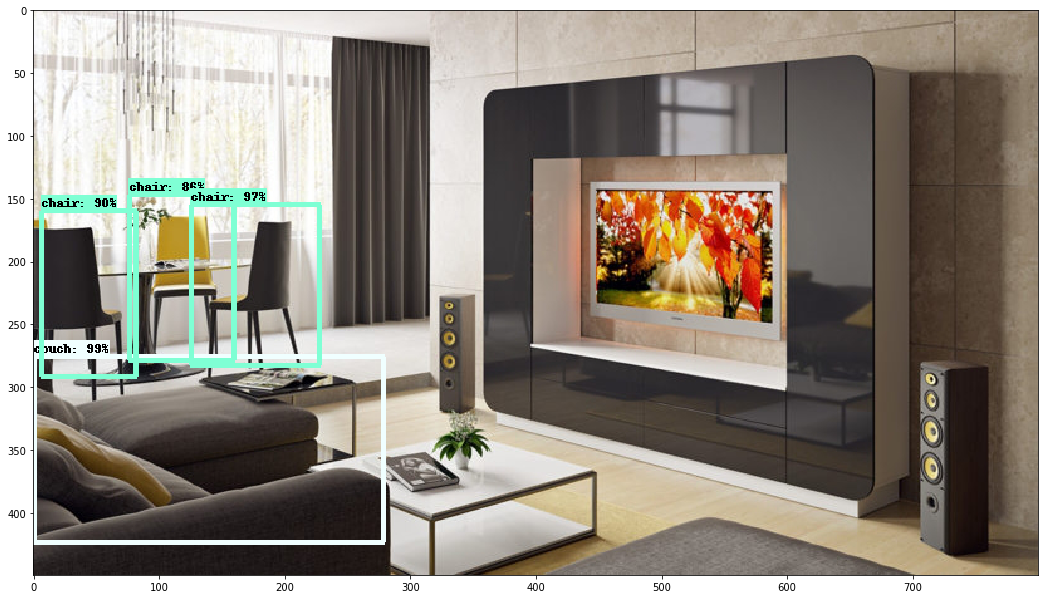

In [25]:
mebel_clf.visualize(TEST_IMAGES_PATH + '4.jpg')

## Классификация тестового датасета

In [43]:
ids_to_class_labels = {y:x for x,y in classes_labels_to_ids.items()}
class_labels = list(classes_labels_to_ids)

In [46]:
def convert_coords(coords):
    min_y, min_x, max_y, max_x = coords
    min_x = float(min_x)
    min_y = float(min_y)
    max_x = float(max_x)
    max_y = float(max_y)
    return [[min_x, min_y],[max_x, min_y],[max_x, max_y],[min_x, max_y],[min_x, min_y]]

In [47]:
def predictions_to_res(predictions):
    results = {}
    for class_label in class_labels:
        results[class_label] = []
    for bbox, score, class_id in zip(predictions[0][0], predictions[1][0], predictions[2][0]):
        if score >= 0.1:
            results[ids_to_class_labels[class_id]].append(convert_coords(bbox))
    return results

In [48]:
result_df = pd.DataFrame()
for index, row in test_df.iterrows():
    predictions = mebel_clf.get_predictions(TEST_IMAGES/'{}.jpg'.format(index))
    result = predictions_to_res(predictions)
    prediction_str = json.dumps({"aabb":result})
    result_df = result_df.append([[index, row['input'], prediction_str]])
    sys.stderr.write('\rProcessed image {} of {}'.format(index, test_df.shape[0]))

Processed image 3715 of 3713

In [49]:
result_df.columns = ['id', 'input', 'prediction']

In [50]:
result_df.to_csv('whatever_submission.csv', index=False)

In [51]:
print("Done")

Done
